# STEP 2 - Making RL PySC2 Agent

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Runnning 'Agent code' on jupyter notebook 

In [2]:
# unfortunately, PySC2 uses Abseil, which treats python code as if its run like an app
# This does not play well with jupyter notebook
# So we will need to monkeypatch sys.argv


import sys
#sys.argv = ["python", "--map", "AbyssalReef"]
sys.argv = ["python", "--map", "Simple64"]

# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS-IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Run an agent."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import threading

from absl import app
from absl import flags
from future.builtins import range  # pylint: disable=redefined-builtin

from pysc2 import maps
from pysc2.env import available_actions_printer
from pysc2.env import run_loop
from pysc2.env import sc2_env
from pysc2.lib import point_flag
from pysc2.lib import stopwatch

FLAGS = flags.FLAGS

# because of Abseil's horrible design for running code underneath Colabs
# We have to pull out this ugly hack from the hat
if "flags_defined" not in globals():
    flags.DEFINE_bool("render", True, "Whether to render with pygame.")
    point_flag.DEFINE_point("feature_screen_size", "84",
                            "Resolution for screen feature layers.")
    point_flag.DEFINE_point("feature_minimap_size", "64",
                            "Resolution for minimap feature layers.")
    point_flag.DEFINE_point("rgb_screen_size", None,
                            "Resolution for rendered screen.")
    point_flag.DEFINE_point("rgb_minimap_size", None,
                            "Resolution for rendered minimap.")
    flags.DEFINE_enum("action_space", None, sc2_env.ActionSpace._member_names_,  # pylint: disable=protected-access
                      "Which action space to use. Needed if you take both feature "
                      "and rgb observations.")
    flags.DEFINE_bool("use_feature_units", True,
                      "Whether to include feature units.")
    flags.DEFINE_bool("disable_fog", False, "Whether to disable Fog of War.")

    flags.DEFINE_integer("max_agent_steps", 0, "Total agent steps.")
    flags.DEFINE_integer("game_steps_per_episode", None, "Game steps per episode.")
    flags.DEFINE_integer("max_episodes", 0, "Total episodes.")
    flags.DEFINE_integer("step_mul", 8, "Game steps per agent step.")
    flags.DEFINE_float("fps", 22.4, "Frames per second to run the game.")

    #flags.DEFINE_string("agent", "sc2.agent.BasicAgent.ZergBasicAgent",
    #                    "Which agent to run, as a python path to an Agent class.")
    #flags.DEFINE_enum("agent_race", "zerg", sc2_env.Race._member_names_,  # pylint: disable=protected-access
    #                  "Agent 1's race.")
    flags.DEFINE_string("agent", "TerranRLAgent",
                        "Which agent to run, as a python path to an Agent class.")
    flags.DEFINE_enum("agent_race", "terran", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 1's race.")

    flags.DEFINE_string("agent2", "Bot", "Second agent, either Bot or agent class.")
    flags.DEFINE_enum("agent2_race", "random", sc2_env.Race._member_names_,  # pylint: disable=protected-access
                      "Agent 2's race.")
    flags.DEFINE_enum("difficulty", "very_easy", sc2_env.Difficulty._member_names_,  # pylint: disable=protected-access
                      "If agent2 is a built-in Bot, it's strength.")

    flags.DEFINE_bool("profile", False, "Whether to turn on code profiling.")
    flags.DEFINE_bool("trace", False, "Whether to trace the code execution.")
    flags.DEFINE_integer("parallel", 1, "How many instances to run in parallel.")

    flags.DEFINE_bool("save_replay", True, "Whether to save a replay at the end.")

    flags.DEFINE_string("map", None, "Name of a map to use.")
    flags.mark_flag_as_required("map")

flags_defined = True

def run_thread(agent_classes, players, map_name, visualize):
  """Run one thread worth of the environment with agents."""
  with sc2_env.SC2Env(
      map_name=map_name,
      players=players,
      agent_interface_format=sc2_env.parse_agent_interface_format(
          feature_screen=FLAGS.feature_screen_size,
          feature_minimap=FLAGS.feature_minimap_size,
          rgb_screen=FLAGS.rgb_screen_size,
          rgb_minimap=FLAGS.rgb_minimap_size,
          action_space=FLAGS.action_space,
          use_feature_units=FLAGS.use_feature_units),
      step_mul=FLAGS.step_mul,
      game_steps_per_episode=FLAGS.game_steps_per_episode,
      disable_fog=FLAGS.disable_fog,
      visualize=visualize) as env:
    env = available_actions_printer.AvailableActionsPrinter(env)
    agents = [agent_cls() for agent_cls in agent_classes]
    run_loop.run_loop(agents, env, FLAGS.max_agent_steps, FLAGS.max_episodes)
    if FLAGS.save_replay:
      env.save_replay(agent_classes[0].__name__)

def main(unused_argv):
  """Run an agent."""
  #stopwatch.sw.enabled = FLAGS.profile or FLAGS.trace
  #stopwatch.sw.trace = FLAGS.trace

  map_inst = maps.get(FLAGS.map)

  agent_classes = []
  players = []

  #agent_module, agent_name = FLAGS.agent.rsplit(".", 1)
  #agent_cls = getattr(importlib.import_module(agent_module), agent_name)
  #agent_classes.append(agent_cls)
  agent_classes.append(TerranRLAgent)
  players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent_race]))

  if map_inst.players >= 2:
    if FLAGS.agent2 == "Bot":
      players.append(sc2_env.Bot(sc2_env.Race[FLAGS.agent2_race],
                                 sc2_env.Difficulty[FLAGS.difficulty]))
    else:
      agent_module, agent_name = FLAGS.agent2.rsplit(".", 1)
      agent_cls = getattr(importlib.import_module(agent_module), agent_name)
      agent_classes.append(agent_cls)
      players.append(sc2_env.Agent(sc2_env.Race[FLAGS.agent2_race]))

  threads = []
  for _ in range(FLAGS.parallel - 1):
    t = threading.Thread(target=run_thread,
                         args=(agent_classes, players, FLAGS.map, False))
    threads.append(t)
    t.start()

  run_thread(agent_classes, players, FLAGS.map, FLAGS.render)

  for t in threads:
    t.join()

  if FLAGS.profile:
    pass
    #print(stopwatch.sw)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Creating a RL PySC2 Agent

In [3]:
import random
import time
import math

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [ ]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

    def transformLocation(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]
        
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        time.sleep(0.5)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        return actions.FUNCTIONS.no_op()

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 2. Defining Actions

In [ ]:
import random
import time
import math

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
ACTION_DO_NOTHING = 'donothing'
ACTION_SELECT_SCV = 'selectscv'
ACTION_BUILD_SUPPLY_DEPOT = 'buildsupplydepot'
ACTION_BUILD_BARRACKS = 'buildbarracks'
ACTION_SELECT_BARRACKS = 'selectbarracks'
ACTION_BUILD_MARINE = 'buildmarine'
ACTION_SELECT_ARMY = 'selectarmy'
ACTION_ATTACK = 'attack'

smart_actions = [
    ACTION_DO_NOTHING,
    ACTION_SELECT_SCV,
    ACTION_BUILD_SUPPLY_DEPOT,
    ACTION_BUILD_BARRACKS,
    ACTION_SELECT_BARRACKS,
    ACTION_BUILD_MARINE,
    ACTION_SELECT_ARMY,
    ACTION_ATTACK,
]

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [ ]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

        self.base_top_left = None 
        self.qlearn = QLearningTable(actions=list(range(len(smart_actions))))

    def transformLocation(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]

    def getMeanLocation(self, unitList):
        sum_x = 0
        sum_y = 0
        for unit in unitList:
            sum_x += unit.x
            sum_y += unit.y
        mean_x = sum_x / len(unitList)
        mean_y = sum_y / len(unitList)
        
        return [mean_x, mean_y]
    
    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.feature_units
                if unit.unit_type == unit_type]

    def can_do(self, obs, action):
        return action in obs.observation.available_actions
    
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        time.sleep(0.5)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        smart_action = smart_actions[random.randrange(0, len(smart_actions) - 1)]
        
        if smart_action == ACTION_DO_NOTHING:
            return actions.FUNCTIONS.no_op()

        elif smart_action == ACTION_SELECT_SCV:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                scvs = self.get_units_by_type(obs, units.Terran.SCV)
                if len(scvs) > 0:
                    scv = random.choice(scvs)
                    if scv.x >= 0 and scv.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (scv.x,
                                                                              scv.y))
        
        elif smart_action == ACTION_BUILD_SUPPLY_DEPOT:
            if self.can_do(obs, actions.FUNCTIONS.Build_SupplyDepot_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 0, int(mean_y), 20)

                    return actions.FUNCTIONS.Build_SupplyDepot_screen("now", target)        
        
        elif smart_action == ACTION_BUILD_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.Build_Barracks_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 20, int(mean_y), 0)

                    return actions.FUNCTIONS.Build_Barracks_screen("now", target)
   
        elif smart_action == ACTION_SELECT_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                barracks = self.get_units_by_type(obs, units.Terran.Barracks)
                if len(barracks) > 0:
                    barrack = random.choice(barracks)
                    if barrack.x >= 0 and barrack.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (barrack.x,
                                                                              barrack.y))
        
        elif smart_action == ACTION_BUILD_MARINE:
            if self.can_do(obs, actions.FUNCTIONS.Train_Marine_quick.id):
                return actions.FUNCTIONS.Train_Marine_quick("queued")
        
        elif smart_action == ACTION_SELECT_ARMY:
            if self.can_do(obs, actions.FUNCTIONS.select_army.id):
                return actions.FUNCTIONS.select_army("select")
        
        elif smart_action == ACTION_ATTACK:
            if self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
                if self.base_top_left:
                    return actions.FUNCTIONS.Attack_minimap("now", [39, 45])
                else:
                    return actions.FUNCTIONS.Attack_minimap("now", [21, 24])
            
        return actions.FUNCTIONS.no_op()

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 3. Defining States

In [ ]:
import random
import time
import math

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
ACTION_DO_NOTHING = 'donothing'
ACTION_SELECT_SCV = 'selectscv'
ACTION_BUILD_SUPPLY_DEPOT = 'buildsupplydepot'
ACTION_BUILD_BARRACKS = 'buildbarracks'
ACTION_SELECT_BARRACKS = 'selectbarracks'
ACTION_BUILD_MARINE = 'buildmarine'
ACTION_SELECT_ARMY = 'selectarmy'
ACTION_ATTACK = 'attack'

smart_actions = [
    ACTION_DO_NOTHING,
    ACTION_SELECT_SCV,
    ACTION_BUILD_SUPPLY_DEPOT,
    ACTION_BUILD_BARRACKS,
    ACTION_SELECT_BARRACKS,
    ACTION_BUILD_MARINE,
    ACTION_SELECT_ARMY,
    ACTION_ATTACK,
]

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [ ]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

        self.base_top_left = None 
        self.qlearn = QLearningTable(actions=list(range(len(smart_actions))))

    def transformLocation(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]

    def getMeanLocation(self, unitList):
        sum_x = 0
        sum_y = 0
        for unit in unitList:
            sum_x += unit.x
            sum_y += unit.y
        mean_x = sum_x / len(unitList)
        mean_y = sum_y / len(unitList)
        
        return [mean_x, mean_y]
    
    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.feature_units
                if unit.unit_type == unit_type]

    def can_do(self, obs, action):
        return action in obs.observation.available_actions
    
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        time.sleep(0.5)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        supply_depot_count = len(self.get_units_by_type(obs, units.Terran.SupplyDepot))

        barracks_count = len(self.get_units_by_type(obs, units.Terran.Barracks))
            
        supply_limit = obs.observation.player.food_cap
        army_supply = obs.observation.player.food_used
        
        current_state = [
            supply_depot_count,
            barracks_count,
            supply_limit,
            army_supply,
        ]
        
        rl_action = self.qlearn.choose_action(str(current_state))
        smart_action = smart_actions[rl_action]
        
        if smart_action == ACTION_DO_NOTHING:
            return actions.FUNCTIONS.no_op()

        elif smart_action == ACTION_SELECT_SCV:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                scvs = self.get_units_by_type(obs, units.Terran.SCV)
                if len(scvs) > 0:
                    scv = random.choice(scvs)
                    if scv.x >= 0 and scv.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (scv.x,
                                                                              scv.y))
        
        elif smart_action == ACTION_BUILD_SUPPLY_DEPOT:
            if self.can_do(obs, actions.FUNCTIONS.Build_SupplyDepot_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 0, int(mean_y), 20)

                    return actions.FUNCTIONS.Build_SupplyDepot_screen("now", target)        
        
        elif smart_action == ACTION_BUILD_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.Build_Barracks_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 20, int(mean_y), 0)

                    return actions.FUNCTIONS.Build_Barracks_screen("now", target)
    
        elif smart_action == ACTION_SELECT_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                barracks = self.get_units_by_type(obs, units.Terran.Barracks)
                if len(barracks) > 0:
                    barrack = random.choice(barracks)
                    if barrack.x >= 0 and barrack.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (barrack.x,
                                                                              barrack.y))
        
        elif smart_action == ACTION_BUILD_MARINE:
            if self.can_do(obs, actions.FUNCTIONS.Train_Marine_quick.id):
                return actions.FUNCTIONS.Train_Marine_quick("queued")
        
        elif smart_action == ACTION_SELECT_ARMY:
            if self.can_do(obs, actions.FUNCTIONS.select_army.id):
                return actions.FUNCTIONS.select_army("select")
        
        elif smart_action == ACTION_ATTACK:
            if self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
                if self.base_top_left:
                    return actions.FUNCTIONS.Attack_minimap("now", [39, 45])
                else:
                    return actions.FUNCTIONS.Attack_minimap("now", [21, 24])
            
        return actions.FUNCTIONS.no_op()

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 4. Defining Rewards

In [ ]:
import random
import time
import math

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
ACTION_DO_NOTHING = 'donothing'
ACTION_SELECT_SCV = 'selectscv'
ACTION_BUILD_SUPPLY_DEPOT = 'buildsupplydepot'
ACTION_BUILD_BARRACKS = 'buildbarracks'
ACTION_SELECT_BARRACKS = 'selectbarracks'
ACTION_BUILD_MARINE = 'buildmarine'
ACTION_SELECT_ARMY = 'selectarmy'
ACTION_ATTACK = 'attack'

smart_actions = [
    ACTION_DO_NOTHING,
    ACTION_SELECT_SCV,
    ACTION_BUILD_SUPPLY_DEPOT,
    ACTION_BUILD_BARRACKS,
    ACTION_SELECT_BARRACKS,
    ACTION_BUILD_MARINE,
    ACTION_SELECT_ARMY,
    ACTION_ATTACK,
]

KILL_UNIT_REWARD = 0.2
KILL_BUILDING_REWARD = 0.5

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [ ]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

        self.base_top_left = None 
        self.qlearn = QLearningTable(actions=list(range(len(smart_actions))))
        
        self.previous_killed_unit_score = 0
        self.previous_killed_building_score = 0

    def transformLocation(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]

    def getMeanLocation(self, unitList):
        sum_x = 0
        sum_y = 0
        for unit in unitList:
            sum_x += unit.x
            sum_y += unit.y
        mean_x = sum_x / len(unitList)
        mean_y = sum_y / len(unitList)
        
        return [mean_x, mean_y]
    
    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.feature_units
                if unit.unit_type == unit_type]

    def can_do(self, obs, action):
        return action in obs.observation.available_actions
    
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        time.sleep(0.5)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        supply_depot_count = len(self.get_units_by_type(obs, units.Terran.SupplyDepot))

        barracks_count = len(self.get_units_by_type(obs, units.Terran.Barracks))
            
        supply_limit = obs.observation.player.food_cap
        army_supply = obs.observation.player.food_used
        
        killed_unit_score = obs.observation.score_cumulative.killed_value_units
        killed_building_score = obs.observation.score_cumulative.killed_value_structures
        
        current_state = [
            supply_depot_count,
            barracks_count,
            supply_limit,
            army_supply,
        ]
        
        reward = 0
        
        if killed_unit_score > self.previous_killed_unit_score:
            reward += KILL_UNIT_REWARD
                
        if killed_building_score > self.previous_killed_building_score:
            reward += KILL_BUILDING_REWARD
                
        rl_action = self.qlearn.choose_action(str(current_state))
        smart_action = smart_actions[rl_action]
        
        self.previous_killed_unit_score = killed_unit_score
        self.previous_killed_building_score = killed_building_score
        
        if smart_action == ACTION_DO_NOTHING:
            return actions.FUNCTIONS.no_op()

        elif smart_action == ACTION_SELECT_SCV:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                scvs = self.get_units_by_type(obs, units.Terran.SCV)
                if len(scvs) > 0:
                    scv = random.choice(scvs)
                    if scv.x >= 0 and scv.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (scv.x,
                                                                              scv.y))
        
        elif smart_action == ACTION_BUILD_SUPPLY_DEPOT:
            if self.can_do(obs, actions.FUNCTIONS.Build_SupplyDepot_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 0, int(mean_y), 20)

                    return actions.FUNCTIONS.Build_SupplyDepot_screen("now", target)        
        
        elif smart_action == ACTION_BUILD_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.Build_Barracks_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 20, int(mean_y), 0)

                    return actions.FUNCTIONS.Build_Barracks_screen("now", target)
    
        elif smart_action == ACTION_SELECT_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                barracks = self.get_units_by_type(obs, units.Terran.Barracks)
                if len(barracks) > 0:
                    barrack = random.choice(barracks)
                    if barrack.x >= 0 and barrack.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (barrack.x,
                                                                              barrack.y))
        
        elif smart_action == ACTION_BUILD_MARINE:
            if self.can_do(obs, actions.FUNCTIONS.Train_Marine_quick.id):
                return actions.FUNCTIONS.Train_Marine_quick("queued")
        
        elif smart_action == ACTION_SELECT_ARMY:
            if self.can_do(obs, actions.FUNCTIONS.select_army.id):
                return actions.FUNCTIONS.select_army("select")
        
        elif smart_action == ACTION_ATTACK:
            if self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
                if self.base_top_left:
                    return actions.FUNCTIONS.Attack_minimap("now", [39, 45])
                else:
                    return actions.FUNCTIONS.Attack_minimap("now", [21, 24])
            
        return actions.FUNCTIONS.no_op()

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 5. Connecting All Up

In [ ]:
import random
import time
import math

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
ACTION_DO_NOTHING = 'donothing'
ACTION_SELECT_SCV = 'selectscv'
ACTION_BUILD_SUPPLY_DEPOT = 'buildsupplydepot'
ACTION_BUILD_BARRACKS = 'buildbarracks'
ACTION_SELECT_BARRACKS = 'selectbarracks'
ACTION_BUILD_MARINE = 'buildmarine'
ACTION_SELECT_ARMY = 'selectarmy'
ACTION_ATTACK = 'attack'

smart_actions = [
    ACTION_DO_NOTHING,
    ACTION_SELECT_SCV,
    ACTION_BUILD_SUPPLY_DEPOT,
    ACTION_BUILD_BARRACKS,
    ACTION_SELECT_BARRACKS,
    ACTION_BUILD_MARINE,
    ACTION_SELECT_ARMY,
    ACTION_ATTACK,
]

KILL_UNIT_REWARD = 0.2
KILL_BUILDING_REWARD = 0.5

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [ ]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

        self.base_top_left = None 
        self.qlearn = QLearningTable(actions=list(range(len(smart_actions))))
        
        self.previous_killed_unit_score = 0
        self.previous_killed_building_score = 0
        
        self.previous_action = None
        self.previous_state = None

    def transformLocation(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]

    def getMeanLocation(self, unitList):
        sum_x = 0
        sum_y = 0
        for unit in unitList:
            sum_x += unit.x
            sum_y += unit.y
        mean_x = sum_x / len(unitList)
        mean_y = sum_y / len(unitList)
        
        return [mean_x, mean_y]
    
    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.feature_units
                if unit.unit_type == unit_type]

    def can_do(self, obs, action):
        return action in obs.observation.available_actions
    
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        #time.sleep(0.5)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        supply_depot_count = len(self.get_units_by_type(obs, units.Terran.SupplyDepot))

        barracks_count = len(self.get_units_by_type(obs, units.Terran.Barracks))
            
        supply_limit = obs.observation.player.food_cap
        army_supply = obs.observation.player.food_used
        
        killed_unit_score = obs.observation.score_cumulative.killed_value_units
        killed_building_score = obs.observation.score_cumulative.killed_value_structures
        
        current_state = [
            supply_depot_count,
            barracks_count,
            supply_limit,
            army_supply,
        ]
        
        if self.previous_action is not None:
            reward = 0
                
            if killed_unit_score > self.previous_killed_unit_score:
                reward += KILL_UNIT_REWARD
                    
            if killed_building_score > self.previous_killed_building_score:
                reward += KILL_BUILDING_REWARD
                
            self.qlearn.learn(str(self.previous_state), self.previous_action, reward, str(current_state))
        
        rl_action = self.qlearn.choose_action(str(current_state))
        smart_action = smart_actions[rl_action]
        
        self.previous_killed_unit_score = killed_unit_score
        self.previous_killed_building_score = killed_building_score
        self.previous_state = current_state
        self.previous_action = rl_action
        
        if smart_action == ACTION_DO_NOTHING:
            return actions.FUNCTIONS.no_op()

        elif smart_action == ACTION_SELECT_SCV:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                scvs = self.get_units_by_type(obs, units.Terran.SCV)
                if len(scvs) > 0:
                    scv = random.choice(scvs)
                    if scv.x >= 0 and scv.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (scv.x,
                                                                              scv.y))
        
        elif smart_action == ACTION_BUILD_SUPPLY_DEPOT:
            if self.can_do(obs, actions.FUNCTIONS.Build_SupplyDepot_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 0, int(mean_y), 20)

                    return actions.FUNCTIONS.Build_SupplyDepot_screen("now", target)        
        
        elif smart_action == ACTION_BUILD_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.Build_Barracks_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformLocation(int(mean_x), 20, int(mean_y), 0)

                    return actions.FUNCTIONS.Build_Barracks_screen("now", target)
    
        elif smart_action == ACTION_SELECT_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                barracks = self.get_units_by_type(obs, units.Terran.Barracks)
                if len(barracks) > 0:
                    barrack = random.choice(barracks)
                    if barrack.x >= 0 and barrack.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (barrack.x,
                                                                              barrack.y))
        
        elif smart_action == ACTION_BUILD_MARINE:
            if self.can_do(obs, actions.FUNCTIONS.Train_Marine_quick.id):
                return actions.FUNCTIONS.Train_Marine_quick("queued")
        
        elif smart_action == ACTION_SELECT_ARMY:
            if self.can_do(obs, actions.FUNCTIONS.select_army.id):
                return actions.FUNCTIONS.select_army("select")
        
        elif smart_action == ACTION_ATTACK:
            if self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
                if self.base_top_left:
                    return actions.FUNCTIONS.Attack_minimap("now", [39, 45])
                else:
                    return actions.FUNCTIONS.Attack_minimap("now", [21, 24])
            
        return actions.FUNCTIONS.no_op()

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 6. Changing Attack Actions

![Reduced attack points in Simple64 map](./images/reduced_attack_points_in_Simple64.png)
image ref : Steven Brown's PySC2 blog


In [ ]:
import random
import time
import math

import numpy as np
import pandas as pd


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [ ]:
ACTION_DO_NOTHING = 'donothing'
ACTION_SELECT_SCV = 'selectscv'
ACTION_BUILD_SUPPLY_DEPOT = 'buildsupplydepot'
ACTION_BUILD_BARRACKS = 'buildbarracks'
ACTION_SELECT_BARRACKS = 'selectbarracks'
ACTION_BUILD_MARINE = 'buildmarine'
ACTION_SELECT_ARMY = 'selectarmy'
ACTION_ATTACK = 'attack'

smart_actions = [
    ACTION_DO_NOTHING,
    ACTION_SELECT_SCV,
    ACTION_BUILD_SUPPLY_DEPOT,
    ACTION_BUILD_BARRACKS,
    ACTION_SELECT_BARRACKS,
    ACTION_BUILD_MARINE,
    ACTION_SELECT_ARMY,
]

#for mm_x in range(0, 64):
#    for mm_y in range(0, 64):
#        smart_actions.append(ACTION_ATTACK + '_' + str(mm_x) + '_' + str(mm_y))

for mm_x in range(0, 64):
    for mm_y in range(0, 64):
        if (mm_x + 1) % 16 == 0 and (mm_y + 1) % 16 == 0:
            smart_actions.append(ACTION_ATTACK + '_' + str(mm_x - 8) + '_' + str(mm_y - 8))

KILL_UNIT_REWARD = 0.2
KILL_BUILDING_REWARD = 0.5

In [ ]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [ ]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

        self.base_top_left = None 
        self.qlearn = QLearningTable(actions=list(range(len(smart_actions))))
        
        self.previous_killed_unit_score = 0
        self.previous_killed_building_score = 0
        
        self.previous_action = None
        self.previous_state = None

    def transformDistance(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]
    
    def transformLocation(self, x, y):
        if not self.base_top_left:
            return [64 - x, 64 - y]
        
        return [x, y]

    def getMeanLocation(self, unitList):
        sum_x = 0
        sum_y = 0
        for unit in unitList:
            sum_x += unit.x
            sum_y += unit.y
        mean_x = sum_x / len(unitList)
        mean_y = sum_y / len(unitList)
        
        return [mean_x, mean_y]
    
    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.feature_units
                if unit.unit_type == unit_type]

    def can_do(self, obs, action):
        return action in obs.observation.available_actions
    
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        #time.sleep(0.5)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        supply_depot_count = len(self.get_units_by_type(obs, units.Terran.SupplyDepot))

        barracks_count = len(self.get_units_by_type(obs, units.Terran.Barracks))
            
        supply_limit = obs.observation.player.food_cap
        army_supply = obs.observation.player.food_used
        
        killed_unit_score = obs.observation.score_cumulative.killed_value_units
        killed_building_score = obs.observation.score_cumulative.killed_value_structures
        
        current_state = [
            supply_depot_count,
            barracks_count,
            supply_limit,
            army_supply,
        ]
        
        if self.previous_action is not None:
            reward = 0
                
            if killed_unit_score > self.previous_killed_unit_score:
                reward += KILL_UNIT_REWARD
                    
            if killed_building_score > self.previous_killed_building_score:
                reward += KILL_BUILDING_REWARD
                
            self.qlearn.learn(str(self.previous_state), self.previous_action, reward, str(current_state))
        
        rl_action = self.qlearn.choose_action(str(current_state))
        smart_action = smart_actions[rl_action]
        
        self.previous_killed_unit_score = killed_unit_score
        self.previous_killed_building_score = killed_building_score
        self.previous_state = current_state
        self.previous_action = rl_action
        
        x = 0
        y = 0
        if '_' in smart_action:
            smart_action, x, y = smart_action.split('_')
        
        if smart_action == ACTION_DO_NOTHING:
            return actions.FUNCTIONS.no_op()

        elif smart_action == ACTION_SELECT_SCV:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                scvs = self.get_units_by_type(obs, units.Terran.SCV)
                if len(scvs) > 0:
                    scv = random.choice(scvs)
                    if scv.x >= 0 and scv.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (scv.x,
                                                                              scv.y))
        
        elif smart_action == ACTION_BUILD_SUPPLY_DEPOT:
            if self.can_do(obs, actions.FUNCTIONS.Build_SupplyDepot_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformDistance(int(mean_x), 0, int(mean_y), 20)

                    return actions.FUNCTIONS.Build_SupplyDepot_screen("now", target)        
        
        elif smart_action == ACTION_BUILD_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.Build_Barracks_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformDistance(int(mean_x), 20, int(mean_y), 0)

                    return actions.FUNCTIONS.Build_Barracks_screen("now", target)
    
        elif smart_action == ACTION_SELECT_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                barracks = self.get_units_by_type(obs, units.Terran.Barracks)
                if len(barracks) > 0:
                    barrack = random.choice(barracks)
                    if barrack.x >= 0 and barrack.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (barrack.x,
                                                                              barrack.y))
        
        elif smart_action == ACTION_BUILD_MARINE:
            if self.can_do(obs, actions.FUNCTIONS.Train_Marine_quick.id):
                return actions.FUNCTIONS.Train_Marine_quick("queued")
        
        elif smart_action == ACTION_SELECT_ARMY:
            if self.can_do(obs, actions.FUNCTIONS.select_army.id):
                return actions.FUNCTIONS.select_army("select")
        
        elif smart_action == ACTION_ATTACK:
            if self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
                return actions.FUNCTIONS.Attack_minimap("now", self.transformLocation(int(x), int(y)))
            
        return actions.FUNCTIONS.no_op()

### [run code]

In [ ]:
if __name__ == "__main__":
  app.run(main)

## 7. Adding Enemy Position to States

![Reduced enemy position grid in Simple64 map](./images/reduced_enemy_position_grid_in_Simple64.png)
image ref : Steven Brown's PySC2 blog

In [15]:
import random
import time
import math
import os.path

import numpy as np
import pandas as pd
from collections import deque
import pickle


from pysc2.agents import base_agent
from pysc2.env import sc2_env
from pysc2.lib import actions, features, units
from absl import app

In [16]:
DATA_FILE = 'rlagent_learning_data'
SCORE_FILE = 'rlagent_learning_score'

ACTION_DO_NOTHING = 'donothing'
ACTION_SELECT_SCV = 'selectscv'
ACTION_BUILD_SUPPLY_DEPOT = 'buildsupplydepot'
ACTION_BUILD_BARRACKS = 'buildbarracks'
ACTION_SELECT_BARRACKS = 'selectbarracks'
ACTION_BUILD_MARINE = 'buildmarine'
ACTION_SELECT_ARMY = 'selectarmy'
ACTION_ATTACK = 'attack'

smart_actions = [
    ACTION_DO_NOTHING,
    ACTION_SELECT_SCV,
    ACTION_BUILD_SUPPLY_DEPOT,
    ACTION_BUILD_BARRACKS,
    ACTION_SELECT_BARRACKS,
    ACTION_BUILD_MARINE,
    ACTION_SELECT_ARMY,
]

#for mm_x in range(0, 64):
#    for mm_y in range(0, 64):
#        smart_actions.append(ACTION_ATTACK + '_' + str(mm_x) + '_' + str(mm_y))

for mm_x in range(0, 64):
    for mm_y in range(0, 64):
        if (mm_x + 1) % 16 == 0 and (mm_y + 1) % 16 == 0:
            smart_actions.append(ACTION_ATTACK + '_' + str(mm_x - 8) + '_' + str(mm_y - 8))

KILL_UNIT_REWARD = 0.2
KILL_BUILDING_REWARD = 0.5

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores

In [12]:
# reference from https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)

        if np.random.uniform() < self.epsilon:
            # choose best action
            # state_action = self.q_table.ix[observation, :]
            state_action = self.q_table.loc[observation, :]

            # some actions have the same value
            state_action = state_action.reindex(np.random.permutation(state_action.index))

            action = state_action.idxmax()
        else:
            # choose random action
            action = np.random.choice(self.actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s_)
        self.check_state_exist(s)

        # q_predict = self.q_table.ix[s, a]
        q_predict = self.q_table.loc[s, a]
        # q_target = r + self.gamma * self.q_table.ix[s_, :].max()
        q_target = r + self.gamma * self.q_table.loc[s_, :].max()

        # update
        # self.q_table.ix[s, a] += self.lr * (q_target - q_predict)
        self.q_table.loc[s, a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series([0] * len(self.actions), index=self.q_table.columns, name=state))

In [26]:
class TerranRLAgent(base_agent.BaseAgent):
    def __init__(self):
        super(TerranRLAgent, self).__init__()

        self.base_top_left = None 
        self.qlearn = QLearningTable(actions=list(range(len(smart_actions))))
        
        self.previous_killed_unit_score = 0
        self.previous_killed_building_score = 0
        
        self.previous_action = None
        self.previous_state = None
        
        if os.path.isfile(DATA_FILE + '.gz'):
            self.qlearn.q_table = pd.read_pickle(DATA_FILE + '.gz', compression='gzip')

    def transformDistance(self, x, x_distance, y, y_distance):
        if not self.base_top_left:
            return [x - x_distance, y - y_distance]
        
        return [x + x_distance, y + y_distance]
    
    def transformLocation(self, x, y):
        if not self.base_top_left:
            return [64 - x, 64 - y]
        
        return [x, y]
    
    def getMeanLocation(self, unitList):
        sum_x = 0
        sum_y = 0
        for unit in unitList:
            sum_x += unit.x
            sum_y += unit.y
        mean_x = sum_x / len(unitList)
        mean_y = sum_y / len(unitList)
        
        return [mean_x, mean_y]

    def unit_type_is_selected(self, obs, unit_type):
        if (len(obs.observation.single_select) > 0 and
            obs.observation.single_select[0].unit_type == unit_type):
              return True

        if (len(obs.observation.multi_select) > 0 and
            obs.observation.multi_select[0].unit_type == unit_type):
              return True

        return False

    def get_units_by_type(self, obs, unit_type):
        return [unit for unit in obs.observation.feature_units
                if unit.unit_type == unit_type]

    def can_do(self, obs, action):
        return action in obs.observation.available_actions
    
    def step(self, obs):
        super(TerranRLAgent, self).step(obs)

        #time.sleep(0.5)
        
        if obs.last():
            self.qlearn.q_table.to_pickle(DATA_FILE + '.gz', 'gzip')
            
            scores_window.append(obs.reward)  # save most recent reward
            win_rate = scores_window.count(1)/len(scores_window)*100
            tie_rate = scores_window.count(0)/len(scores_window)*100
            lost_rate = scores_window.count(-1)/len(scores_window)*100
            
            scores.append([win_rate, tie_rate, lost_rate])  # save most recent score(win_rate, tie_rate, lost_rate)
            with open(SCORE_FILE + '.txt', "wb") as fp:
                pickle.dump(scores, fp)
        
        if obs.first():
            player_y, player_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.SELF).nonzero()
            self.base_top_left = 1 if player_y.any() and player_y.mean() <= 31 else 0

        supply_depot_count = len(self.get_units_by_type(obs, units.Terran.SupplyDepot))

        barracks_count = len(self.get_units_by_type(obs, units.Terran.Barracks))
            
        supply_limit = obs.observation.player.food_cap
        army_supply = obs.observation.player.food_used
        
        killed_unit_score = obs.observation.score_cumulative.killed_value_units
        killed_building_score = obs.observation.score_cumulative.killed_value_structures
        
#        current_state = np.zeros(5000)
#        current_state[0] = supply_depot_count
#        current_state[1] = barracks_count
#        current_state[2] = supply_limit
#        current_state[3] = army_supply
#
#        hot_squares = np.zeros(4096)        
#        enemy_y, enemy_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.ENEMY).nonzero()
#        for i in range(0, len(enemy_y)):
#            y = int(enemy_y[i])
#            x = int(enemy_x[i])
#            
#            hot_squares[((y - 1) * 64) + (x - 1)] = 1
#        
#        if not self.base_top_left:
#            hot_squares = hot_squares[::-1]
#        
#        for i in range(0, 4096):
#            current_state[i + 4] = hot_squares[i]

        current_state = np.zeros(20)
        current_state[0] = supply_depot_count
        current_state[1] = barracks_count
        current_state[2] = supply_limit
        current_state[3] = army_supply

        hot_squares = np.zeros(16)        
        enemy_y, enemy_x = (obs.observation.feature_minimap.player_relative == features.PlayerRelative.ENEMY).nonzero()
        for i in range(0, len(enemy_y)):
            y = int(math.ceil((enemy_y[i] + 1) / 16))
            x = int(math.ceil((enemy_x[i] + 1) / 16))
            
            hot_squares[((y - 1) * 4) + (x - 1)] = 1
        
        if not self.base_top_left:
            hot_squares = hot_squares[::-1]
        
        for i in range(0, 16):
            current_state[i + 4] = hot_squares[i] 
            
        if self.previous_action is not None:
            reward = 0
                
            if killed_unit_score > self.previous_killed_unit_score:
                reward += KILL_UNIT_REWARD
                    
            if killed_building_score > self.previous_killed_building_score:
                reward += KILL_BUILDING_REWARD
                
            self.qlearn.learn(str(self.previous_state), self.previous_action, reward, str(current_state))
        
        rl_action = self.qlearn.choose_action(str(current_state))
        smart_action = smart_actions[rl_action]
        
        self.previous_killed_unit_score = killed_unit_score
        self.previous_killed_building_score = killed_building_score
        self.previous_state = current_state
        self.previous_action = rl_action
        
        x = 0
        y = 0
        if '_' in smart_action:
            smart_action, x, y = smart_action.split('_')
        
        if smart_action == ACTION_DO_NOTHING:
            return actions.FUNCTIONS.no_op()

        elif smart_action == ACTION_SELECT_SCV:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                scvs = self.get_units_by_type(obs, units.Terran.SCV)
                if len(scvs) > 0:
                    scv = random.choice(scvs)
                    if scv.x >= 0 and scv.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (scv.x,
                                                                              scv.y))
        
        elif smart_action == ACTION_BUILD_SUPPLY_DEPOT:
            if self.can_do(obs, actions.FUNCTIONS.Build_SupplyDepot_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformDistance(int(mean_x), 0, int(mean_y), 20)

                    return actions.FUNCTIONS.Build_SupplyDepot_screen("now", target)        
        
        elif smart_action == ACTION_BUILD_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.Build_Barracks_screen.id):
                ccs = self.get_units_by_type(obs, units.Terran.CommandCenter)
                if len(ccs) > 0:
                    mean_x, mean_y = self.getMeanLocation(ccs)
                    target = self.transformDistance(int(mean_x), 20, int(mean_y), 0)

                    return actions.FUNCTIONS.Build_Barracks_screen("now", target)
    
        elif smart_action == ACTION_SELECT_BARRACKS:
            if self.can_do(obs, actions.FUNCTIONS.select_point.id):
                barracks = self.get_units_by_type(obs, units.Terran.Barracks)
                if len(barracks) > 0:
                    barrack = random.choice(barracks)
                    if barrack.x >= 0 and barrack.y >= 0:
                        return actions.FUNCTIONS.select_point("select", (barrack.x,
                                                                              barrack.y))
        
        elif smart_action == ACTION_BUILD_MARINE:
            if self.can_do(obs, actions.FUNCTIONS.Train_Marine_quick.id):
                return actions.FUNCTIONS.Train_Marine_quick("queued")
        
        elif smart_action == ACTION_SELECT_ARMY:
            if self.can_do(obs, actions.FUNCTIONS.select_army.id):
                return actions.FUNCTIONS.select_army("select")
        
        elif smart_action == ACTION_ATTACK:
            #if self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
            if not self.unit_type_is_selected(obs, units.Terran.SCV) and self.can_do(obs, actions.FUNCTIONS.Attack_minimap.id):
                return actions.FUNCTIONS.Attack_minimap("now", self.transformLocation(int(x), int(y)))
            
        return actions.FUNCTIONS.no_op()

### [run code]

In [27]:
if __name__ == "__main__":
  app.run(main)

I0827 13:40:14.084501 4423970240 sc_process.py:135] Launching SC2: /Applications/StarCraft II/Versions/Base81102/SC2.app/Contents/MacOS/SC2 -listen 127.0.0.1 -port 21377 -dataDir /Applications/StarCraft II/ -tempDir /var/folders/kl/h0d5qxj551x0d2y091w17l1h0000gn/T/sc-cex3_4wt/ -displayMode 0 -windowwidth 640 -windowheight 480 -windowx 50 -windowy 50
I0827 13:40:14.112885 4423970240 remote_controller.py:166] Connecting to: ws://127.0.0.1:21377/sc2api, attempt: 0, running: True
I0827 13:40:15.122327 4423970240 remote_controller.py:166] Connecting to: ws://127.0.0.1:21377/sc2api, attempt: 1, running: True
I0827 13:40:16.125180 4423970240 remote_controller.py:166] Connecting to: ws://127.0.0.1:21377/sc2api, attempt: 2, running: True
I0827 13:40:17.131703 4423970240 remote_controller.py:166] Connecting to: ws://127.0.0.1:21377/sc2api, attempt: 3, running: True
I0827 13:40:18.134363 4423970240 remote_controller.py:166] Connecting to: ws://127.0.0.1:21377/sc2api, attempt: 4, running: True
I08

   0/no_op                                              ()
   1/move_camera                                        (1/minimap [64, 64])
   2/select_point                                       (6/select_point_act [4]; 0/screen [84, 84])
   3/select_rect                                        (7/select_add [2]; 0/screen [84, 84]; 2/screen2 [84, 84])
   4/select_control_group                               (4/control_group_act [5]; 5/control_group_id [10])
 264/Harvest_Gather_screen                              (3/queued [2]; 0/screen [84, 84])
  12/Attack_screen                                      (3/queued [2]; 0/screen [84, 84])
  13/Attack_minimap                                     (3/queued [2]; 1/minimap [64, 64])
 269/Harvest_Return_quick                               (3/queued [2])
 274/HoldPosition_quick                                 (3/queued [2])
 549/Effect_Spray_minimap                               (3/queued [2]; 1/minimap [64, 64])
  44/Build_CommandCenter_screen        

I0827 13:41:39.752333 4423970240 sc2_env.py:722] Episode 1 finished after 17024 game steps. Outcome: [-1], reward: [-1], score: [7705]
I0827 13:41:43.965456 4423970240 sc2_env.py:506] Starting episode 2: [terran, random] on Simple64
I0827 13:42:56.711888 4423970240 sc2_env.py:722] Episode 2 finished after 21952 game steps. Outcome: [-1], reward: [-1], score: [8550]
I0827 13:43:00.968086 4423970240 sc2_env.py:506] Starting episode 3: [terran, random] on Simple64
I0827 13:43:01.929543 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.930707 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.931674 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.934917 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.935953 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.936646 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.938066 123145503141888 sc2_env.py:752] Environment Close
I0827 13:43:01.945103 12314550

Took 229.862 seconds for 7722 steps: 33.594 fps


I0827 13:44:43.316385 4423970240 sc2_env.py:752] Environment Close
I0827 13:44:43.319229 4423970240 sc_process.py:232] Shutdown gracefully.
I0827 13:44:43.319980 4423970240 sc_process.py:210] Shutdown with return code: 1


ConnectionError: Error during save_replay: Socket error: [Errno 54] Connection reset by peer

### [Winning rate graph]

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
with open(SCORE_FILE + '.txt', "rb") as fp:
    scores = pickle.load(fp)

In [36]:
np_scores = np.array(scores)

[[  0.   0. 100.]
 [  0.   0. 100.]
 [  0.   0. 100.]
 [  0.  20.  80.]
 [ 10.  20.  70.]]


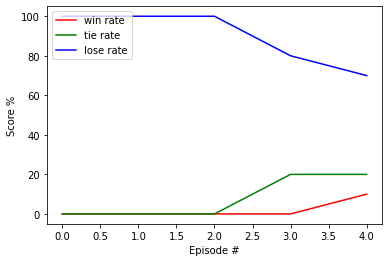

In [37]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(np_scores)), np_scores.T[0], color='r', label='win rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[1], color='g', label='tie rate')
plt.plot(np.arange(len(np_scores)), np_scores.T[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc=2)
plt.show()

In [34]:
scores

[[0.0, 0.0, 100.0], [0.0, 0.0, 100.0], [0.0, 0.0, 100.0]]

ValueError: x and y must have same first dimension, but have shapes (5,) and (3,)

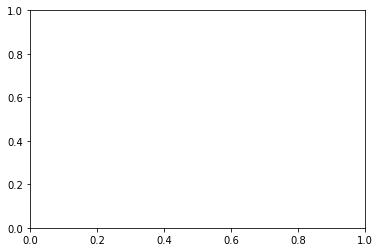

In [35]:
scores = [[0.0, 0.0, 100.0], [0.0, 0.0, 100.0], [0.0, 0.0, 100.0], [0.0, 20.0, 80.0], [10.0, 20.0, 70.0]]

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores[0], color='r', label='win rate')
plt.plot(np.arange(len(scores)), scores[1], color='g', label='tie rate')
plt.plot(np.arange(len(scores)), scores[2], color='b', label='lose rate')
plt.ylabel('Score %')
plt.xlabel('Episode #')
plt.legend(loc=2)
plt.show()